

<center> <h1> Evolution of emotions conveyed by media and their link with the society state </h1> 
<h2> Project Milestone 2 </h2> </center>

<h2> Data collection </h2> 

<u> Source location related data : </u>

When we started processing the data located on the cluster (*'/datasets/gdeltv2'*), we encountered a serious issue : very surprisingly, the dataset does not contain any record related to the media source location. However, we planned in Milestone 1 to focus our project on the specificity of the medias related to their home country.
Thus we spent a lot of time on trying to find ways to circumvent this issue and get information about the source location by other means.
<br>

<ol>
    <li>First, we looked at URL extensions. Indeed, some countries have specific URL extentions (‘.fr’, ‘.it’, etc), and we can use this criterion to filter event mentions.
However, this solution is clearly not very representative because 51% of the sources have a ‘.com’ extension, which is not informative. Moreover, countries like the USA only use ‘.com’ extensions. </li> <br>
    
   <li>Then, we chose a different strategy : we searched for different rankings (e.g. <a href="https://www.cision.com/us/2014/06/top-10-us-daily-newspapers/"> top-10-US-daily-newspapers </a> ) to get the main online medias in a small sample of countries (France, USA). Then we stored these lists of sources and we filtered the event mentions dataset to get medias related to these sources. If we base these queries on relevant information (selection of the principal medias), this strategy can be a good option. However, it requires a lot of manual work, and we had many issues related to the string filter used. Indeed, if fetching only the sources whose name is strictly <i>‘foxnews.com’</i> for example, one would miss <i>'foxcarolina.com'</i> and all the other state-specific or city-specific related webpages. But if we set a very open regular expression like ‘%fox%' or '%wsj%' (for the Wall Street Journal), we get a lot of false negatives like <i>'thenewsjournal.net'</i> or <i>'ctnewsjunkie.com'</i>. 
   Eventually, we decided to not use this strategy because of its too large uncertainty.</li> <br>



   <li>Lastly, we discovered that GDELT generated exactly what we needed: <i>'sources_by_country.csv'</i> a table that matches the sources names ('Domain') with the FIPS-code of their country. This table was generated in may 2018 and is based on the gdelt dataset. It is not perfectly accurate but gives us a sufficient precise information (more informations on <a href=“https://blog.gdeltproject.org/mapping-the-media-a-geographic-lookup-of-gdelts-sources/”> gdelt blog</a>). </li> <br>
   
</ol> 

From now on, we will use Google BigQuery to make queries related to sources locations. The other big advantage of this tool, is that queries are running very fast, whereas when using the cluster, we wait sometimes a whole day for our job to be executed because of the queue.


<u> Data bias </u>

It seems to us that the Gdelt dataset is very biased.
First of all, US are over-represented : 37% of all sources are american.
Moreover ADD INFO 

Thus, knowing this fact, we have to be very carreful in our analysis.

<u> How to quantify negativeness ? </u>

A first solution would be to study the very complex but interesting emotional features recorded in the `GCAM` field of GKG files. However, the GKG dataset is huge and we quickly noticed that any query made on it was very long to execute.
Otherwise, we can simply use the `MentionDocTone field` of the eventmentions table (or `AvgTone` field for the event table): this classification is only binary but it is still informative and anyway the algorithms used to compute it are close to the ones used to compute the GCAM field.


## Data processing

In [1]:
import findspark
findspark.init()
import matplotlib.pyplot as plt
from pyspark.sql.types import *
import datetime as dt
from pyspark.sql.functions import *
import pandas as pd
import numpy as np
import scipy as sp
from pyspark.sql import *
%matplotlib inline
import seaborn as sn
sn.set(color_codes=True)
spark = SparkSession.builder.getOrCreate()

### 1. Are the medias becoming more and more anxiogenic ? Is there a specific trend during a year time ?

In order to determine whether medias are becoming more and more anxiogenic over time, we intented to notice the evolution of the mediatic tone over time. We first focused on intervals of 90 days, thus seasons of the year, and compute the overall average tone, comprise all the mentions comprised in the dataset.

However, the time intervall available in this dataset is very short (it starts only in 2014), thus we will not be able to see long-term trends.

We first extracted the dataset "file_mentions_year_month_day.parquet" in format parquet but not with all its columns. Since we focus our analysis on the time, media source and its tone, we only extracted "MentionDocTone, MentionTimeDate, MentionSourceName" columns. In addition we created a "Year-Month-Day" column which is in Date type to ease creating time intervals afterwards. 

The following python script helps us to get the dataset from cluster:

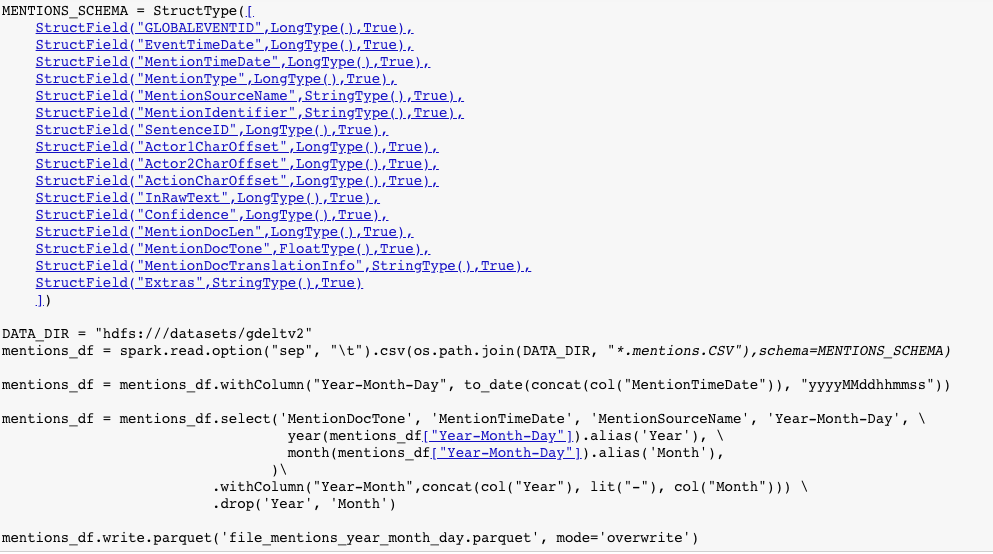

In [6]:
from IPython.display import Image
Image('python_script.png', width=800,height=600)

Once we have the data in our local drive, we can process it on jupyter notebook.

In [7]:
#Reading the parquet file
mentions_df = spark.read.parquet("/Users/sinangokce/Desktop/Project_ESKI/ADA_Project/Data/file_mentions_year_month_day.parquet")

In [8]:
#The column types of mentions_df
mentions_df

DataFrame[MentionDocTone: float, MentionTimeDate: bigint, MentionSourceName: string, Year-Month-Day: date, Year-Month: string]

In [9]:
#Creating 90 days (season) intervals
mentions_df = mentions_df.groupBy(window(mentions_df['Year-Month-Day'], \
                                                           "90 days", \
                                                           startTime = "24 days"
                                                          ) \
                                 ) \
                        .agg(mean("MentionDocTone")) \

In [10]:
mentions_df = mentions_df.withColumn("start", mentions_df.window.start.cast("string")) \
                         .withColumn("end", mentions_df.window.end.cast("string")) \
                         .sort('start', ascending = True) \
                         .select('start', 'end', 'avg(MentionDocTone)')

In [11]:
mentions_Pandas_df = mentions_df.toPandas()

In [12]:
mentions_Pandas_df["interval"] = "[" + mentions_Pandas_df["start"] + "; " +\
                                       mentions_Pandas_df["end"] + ")"
mentions_Pandas_df = mentions_Pandas_df[['start', 'end', 'interval', 'avg(MentionDocTone)']]

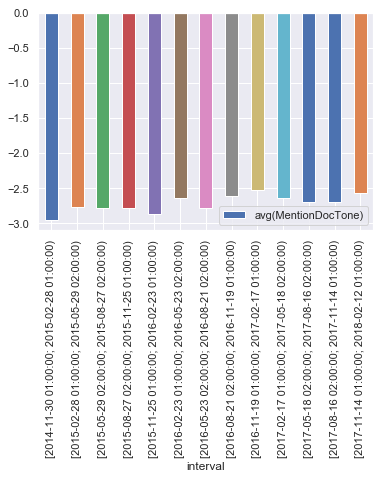

In [13]:
mentions_Pandas_df.plot.bar(x='interval', y='avg(MentionDocTone)')

This plot show no remarkable trend of the mediatic tone. This is a deceiving result, however it may be due to the very short time intervall of the dataset.

Then, we decided to observe whether we notice a periodic trend in the way mediatic tone evolves accross year months. For example, is summer more prone to positive news ?

For now (as it was just a first overview to find what was feasible with the dataset), we focused on *'.fr'* and *'.it'* URL-extended sources, in order to observe these trends for French and Italian medias. When using this strategy to get source location, we have to be aware that we are excluding a lot of mentions which have the *'.com'* or *'.net'* extensions for example.

We run a Python script on the cluster (see *'./Codes/get_monthIntervalMentions.py'*) in order to write as parquet files these specific mentions.

In [2]:
fr_mentions = spark.read.parquet("fr_mentions_casted_date.parquet")
fr_mentions = fr_mentions.select('MentionSourceName','MentionDocTone', 'Month')
fr_mentions.show()

+------------------+--------------+-----+
| MentionSourceName|MentionDocTone|Month|
+------------------+--------------+-----+
|         en.rfi.fr|    -3.5971222|   12|
|       thelocal.fr|   -0.22396417|    6|
|diplomatie.gouv.fr|     3.0120482|    6|
|diplomatie.gouv.fr|     3.0120482|    6|
|       thelocal.fr|   -0.22396417|    6|
|       thelocal.fr|   -0.22396417|    6|
|       thelocal.fr|   -0.22396417|    6|
|         en.rfi.fr|      -3.49162|    3|
|         en.rfi.fr|      -3.49162|    3|
|         en.rfi.fr|     -2.868069|    3|
|         en.rfi.fr|      -3.49162|    3|
|         en.rfi.fr|      -3.49162|    3|
|         en.rfi.fr|     1.4035088|    3|
|         en.rfi.fr|      -3.49162|    3|
|         en.rfi.fr|     1.4035088|    3|
|         en.rfi.fr|    -5.9479556|    3|
|         en.rfi.fr|    -5.9479556|    3|
|          inria.fr|     3.4206307|    2|
|          inria.fr|     3.0560272|    2|
|          inria.fr|     1.5261627|    2|
+------------------+--------------

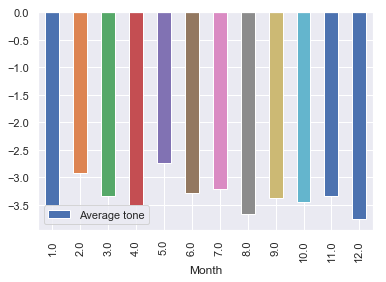

In [3]:
fr_mentions = fr_mentions.groupBy('Month').agg(mean('MentionDocTone').alias('Average tone'))

fr_mentions_Pandas_df = fr_mentions.toPandas()
fr_mentions_Pandas_df.dropna(inplace=True)
fr_mentions_Pandas_df.sort_values('Month', ascending=True, inplace=True)

fr_mentions_Pandas_df.plot.bar(x='Month', y='Average tone')

In [4]:
it_mentions = spark.read.parquet("it_mentions_casted_date.parquet")
it_mentions = it_mentions.select('MentionSourceName','MentionDocTone', 'Month')
it_mentions.show()

+--------------------+--------------+-----+
|   MentionSourceName|MentionDocTone|Month|
+--------------------+--------------+-----+
|         lastampa.it|     1.8962076| null|
|         lastampa.it|     1.8962076| null|
|         lastampa.it|     1.8962076| null|
|         lastampa.it|     1.8962076| null|
|         lastampa.it|     1.8962076| null|
|         lastampa.it|     1.8962076| null|
|         lastampa.it|     1.8962076| null|
|         lastampa.it|     1.8962076| null|
|         lastampa.it|     1.8962076| null|
|firenze.repubblic...|     3.7974684|    6|
|firenze.repubblic...|     3.7974684|    6|
|firenze.repubblic...|     3.7974684|    6|
|lagazzettadelmezz...|           0.0|    6|
|lagazzettadelmezz...|           0.0|    6|
|           cutuli.it|      5.188679|    6|
|           cutuli.it|      5.188679|    6|
|           cutuli.it|      5.188679|    6|
|   gazzettadelsud.it|     -6.590909| null|
|   gazzettadelsud.it|    -7.1017275| null|
|lagazzettadelmezz...|    -7.101

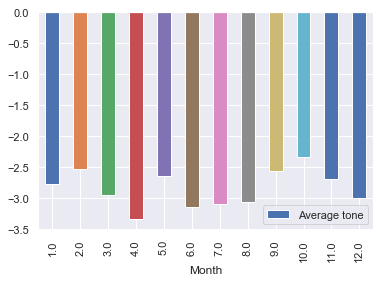

In [5]:
it_mentions = it_mentions.groupBy('Month').agg(mean('MentionDocTone').alias('Average tone'))

it_mentions_Pandas_df = it_mentions.toPandas()
it_mentions_Pandas_df.dropna(inplace=True)
it_mentions_Pandas_df.sort_values('Month', ascending=True, inplace=True)

it_mentions_Pandas_df.plot.bar(x='Month', y='Average tone')

We see that for these two specific countries, we do not have very obvious differences between year months. Thus we drop the idea of searching for a seasonal trend of the tone.

### 2. Can we find different trends in the media tone depending on the event location country ? On the source country ? Is their a link with the Happiness score of the country ?

First, let's look at **mediatic tone with respect to the event location country**.
This analysis would allow us to determine whether the global news concerning a country's events are rather positive or negative. Then, we can see if there is a correlation with the actual happiness level of each country. 

After some googling, we found a research ([world happiness report 2018](http://worldhappiness.report/ed/2018/)) which classifies the contries depending on their happiness scores. In order to relate our events data to this report, we had to create a list of country codes corresponding to the countries in the report. This is because we have only the country code column in our events dataset.

In [3]:
event_df = spark.read.parquet("/Users/sinangokce/Desktop/Project_ESKI/ADA_Project/Data/events_useful.parquet")

In [4]:
event_df

DataFrame[GLOBALEVENTID: bigint, Day_DATE: string, MonthYear_Date: string, NumMentions: bigint, NumSources: bigint, NumArticles: bigint, AvgTone: float, Actor1Geo_CountryCode: string, Actor1Geo_Lat: float, Actor1Geo_Long: float, Actor1Geo_FeatureID: string, Actor2Geo_CountryCode: string, Actor2Geo_Lat: float, Actor2Geo_Long: float, Actor2Geo_FeatureID: string, ActionGeo_CountryCode: string, ActionGeo_Lat: float, ActionGeo_Long: float, ActionGeo_FeatureID: string, DATEADDED: bigint]

In [5]:
event_df = event_df.select('ActionGeo_CountryCode', 'AvgTone')\
                   .groupBy('ActionGeo_CountryCode').agg(mean('AvgTone').alias('Average_tone')) \
                   .sort(asc("Average_tone"))

event_Pandas = event_df.toPandas()
event_Pandas.rename(columns={'ActionGeo_CountryCode':'FIPS'}, inplace=True)

In [10]:
#Reading the customized happiness csv file
happiness_df = pd.read_csv("HappinessCustom.csv", sep=';')
happiness_df.index.name = 'Happiness Rang'
happiness_df.head()

,FIPS,Happiness_score
Happiness Rang,,
0,FI,7.632
1,NO,7.594
2,DK,7.555
3,IC,7.495
4,SZ,7.487


Note that some country values were missing in the Happiness World report, thus we will use inner join to get rid of countries which have no happiness score.

In [11]:
AvgTone_happiness = pd.merge(event_Pandas, happiness_df, how='inner', on='FIPS')
AvgTone_happiness.head()

,FIPS,Average_tone,Happiness_score
0,BY,-4.775766,2.905
1,BK,-4.546209,5.129
2,GZ,-4.452348,4.743
3,CG,-4.350325,4.245
4,SY,-4.304789,3.462


/Users/sinangokce/anaconda3/envs/ada/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0,'The happiness score of different countries')

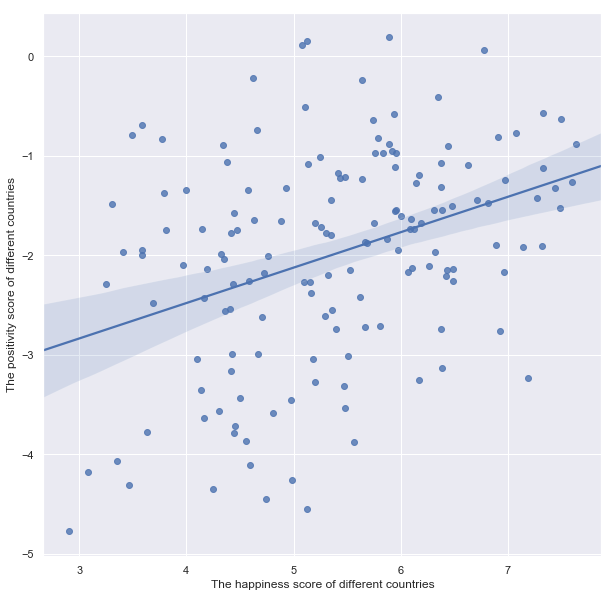

In [12]:
sn.set(rc={'figure.figsize':(10,10)})
sn.regplot('Happiness_score', 'Average_tone', data=AvgTone_happiness)
plt.ylabel("The positivity score of different countries")
plt.xlabel("The happiness score of different countries")

In [ ]:
pearson_coef = AvgTone_happiness['Happiness_score'].corr(AvgTone_happiness['Average_tone'])
print(pearson_coef)

It seems like there is a positive correlation between the mediatic coverage of a country and its actual happiness level. This result should be analyzed more deeply however in the future.

Now, using Google BigQuery tool, let's have a look at the **mediatic tone related to the source country of event mentions**.

The following query was run in order to get the average tone (field `MentionDocTone`) of mentions originating from the same country.
Indeed, by joining the `eventmentions` table to the `sourcesbycountry` table, we could very easily group the mentions by their source FIPS code and compute the average tone :

<img src="query_avgToneBySourceLocation.png" alt="drawing" width="500"/>

After extracting the newly created table `avgToneBySourceLocation_table`, we plotted the result.
Note that the result was splitted between positive and negative average tone in order to have smaller plots, but still be able to visualize the value for each country.

In [23]:
avgTone = spark.read.option("sep",",").option('header', 'true').csv("avgToneBySourceLocation_table.csv")
avgTone.show()
avgTone = avgTone.withColumn('AverageTone', avgTone['AverageTone'].cast(FloatType()))
avgTone.registerTempTable('avgTone_table')

+----+--------------------+
|FIPS|         AverageTone|
+----+--------------------+
|  IT| -1.2266319517342155|
|  WA| -2.1564389385620708|
|  CM| -2.9449712401336963|
|  ML| -1.4626035850125303|
|  MG|-0.24210924465101621|
|  PK| -2.9042192814547048|
|  GH| -1.9078195733342607|
|  KZ| -1.2593573700554748|
|  BM|  -2.257738120596255|
|  IN| -2.6352216561258954|
|  MI| -2.1356432264451626|
|  AV|  1.6529235384892216|
|  LT| -1.7559838499012681|
|  GB|-0.75436355420488421|
|  UK| -2.4232246650674325|
|  AU| -2.9686971461863192|
|  CK| -2.7693001028740176|
|  RS| -2.3112888288017395|
|  TW| -2.4235868152902853|
|  RI|  -1.003833159575332|
+----+--------------------+
only showing top 20 rows



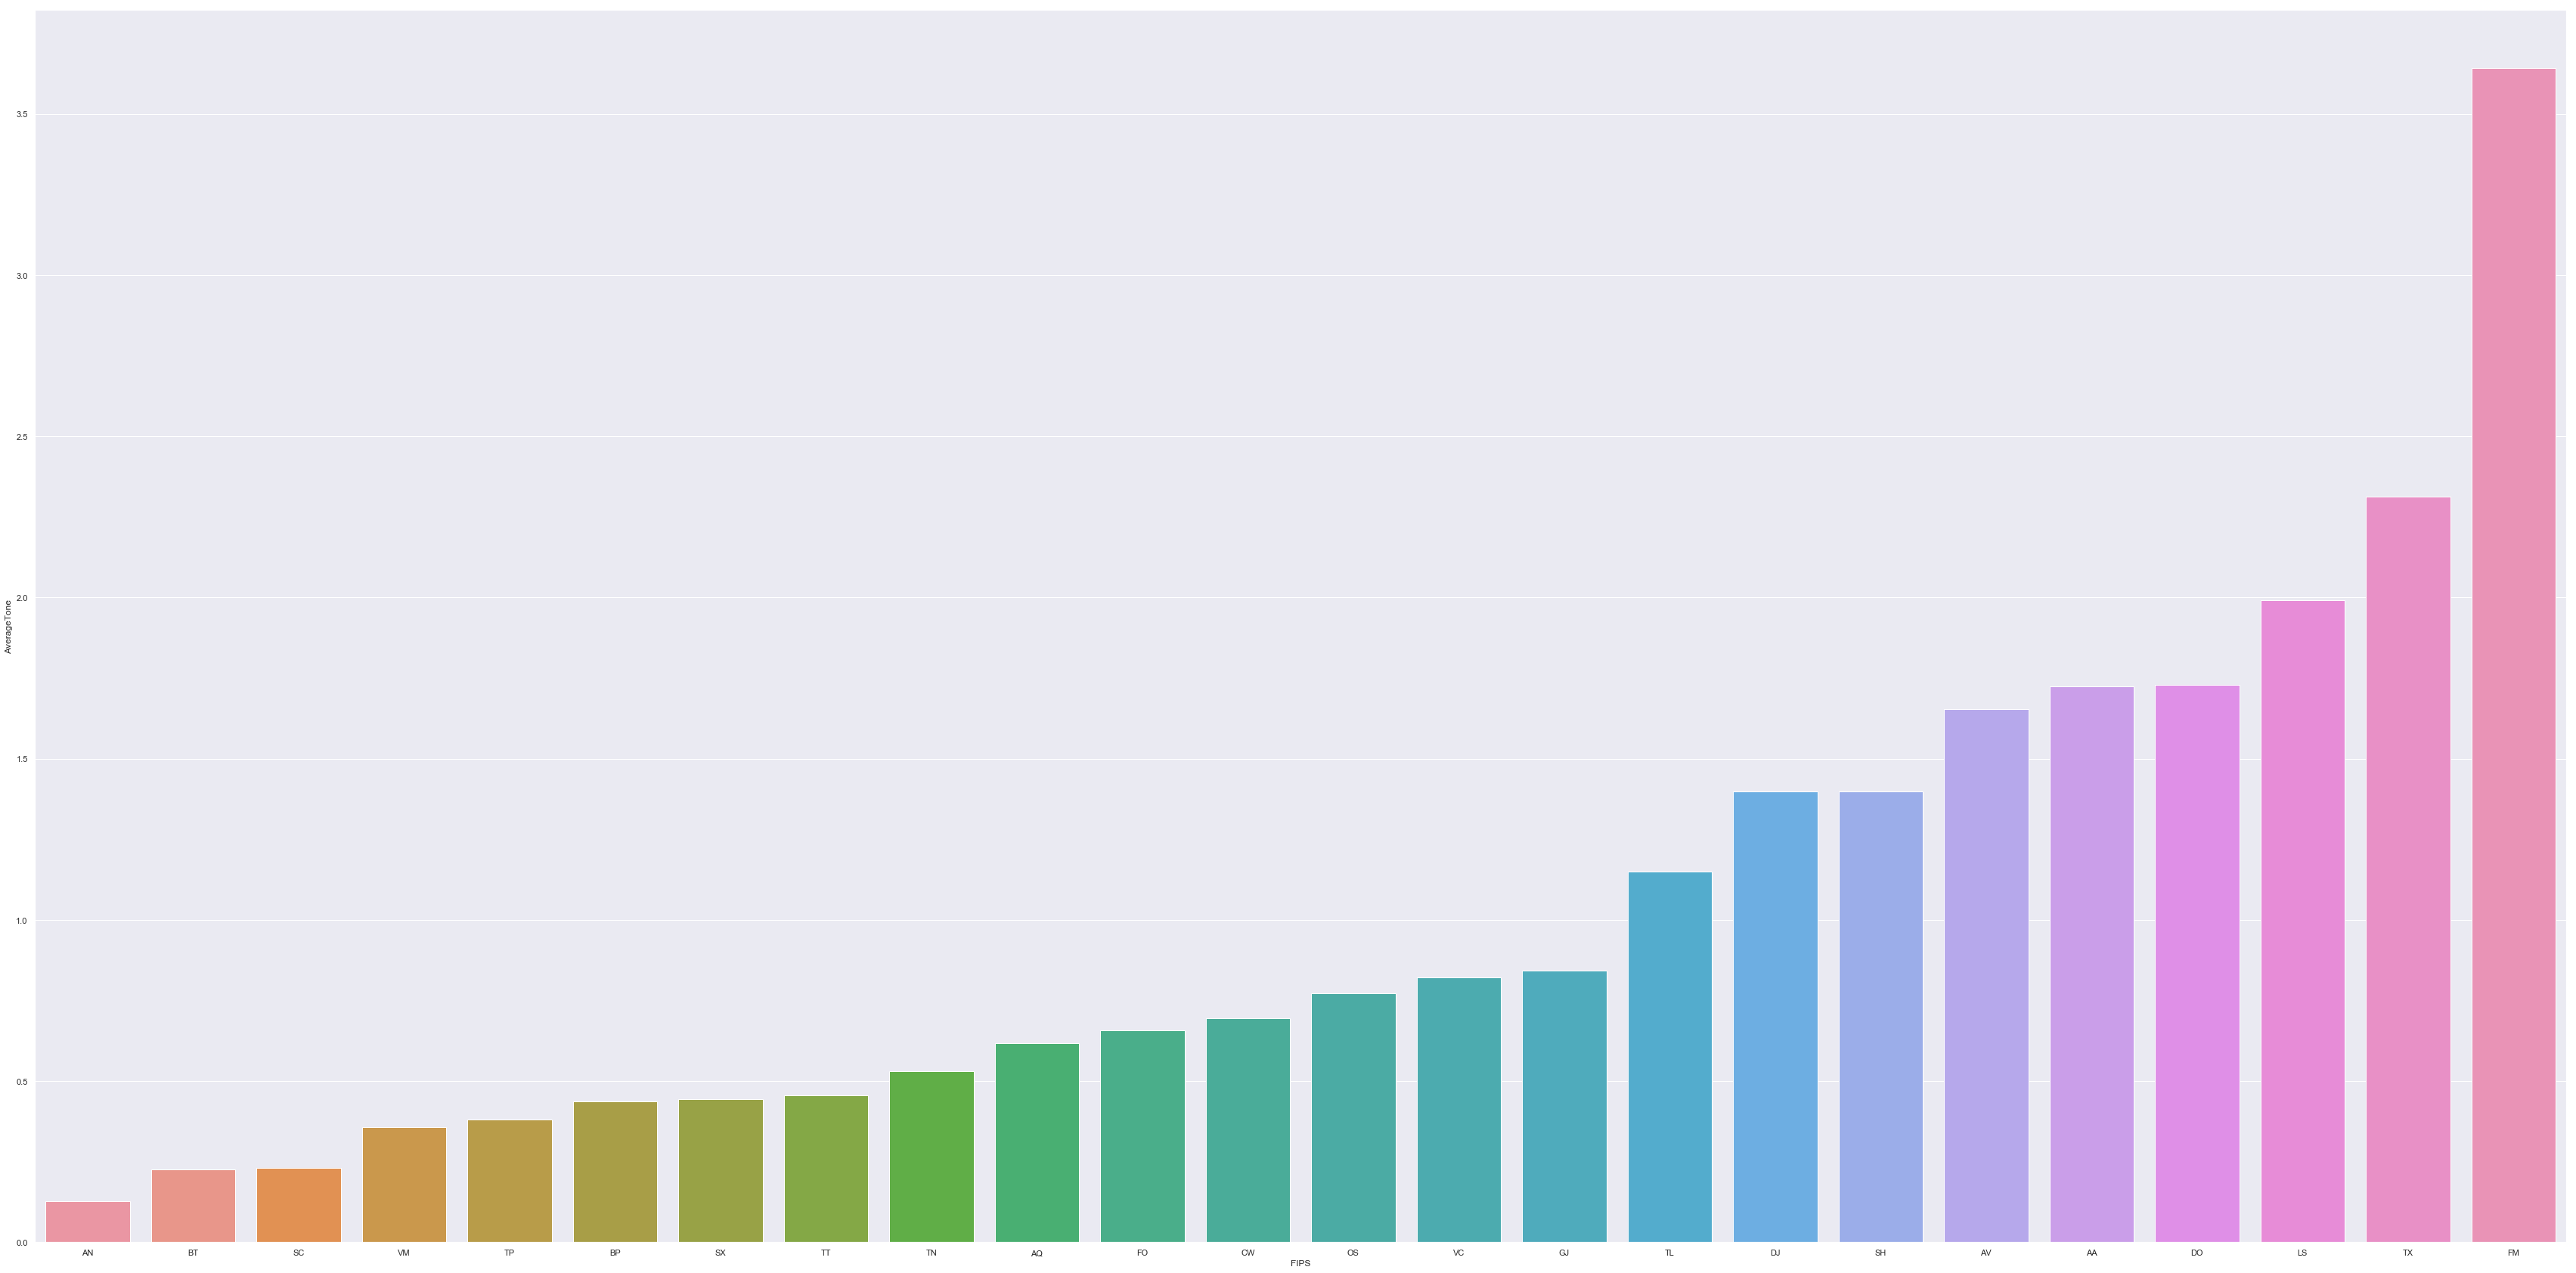

In [24]:
avgTone_pos = avgTone.filter('AverageTone > 0')
avgTone_pos_pandas = avgTone_pos.toPandas()
avgTone_pos_pandas.sort_values('AverageTone', ascending=True, inplace=True)

sn.set(rc={'figure.figsize':(60,30)})
plot = sn.barplot(x='FIPS', y='AverageTone',data=avgTone_pos_pandas)
plt.xlabel("FIPS Codes of countries")
plt.ylabel("The average tone")

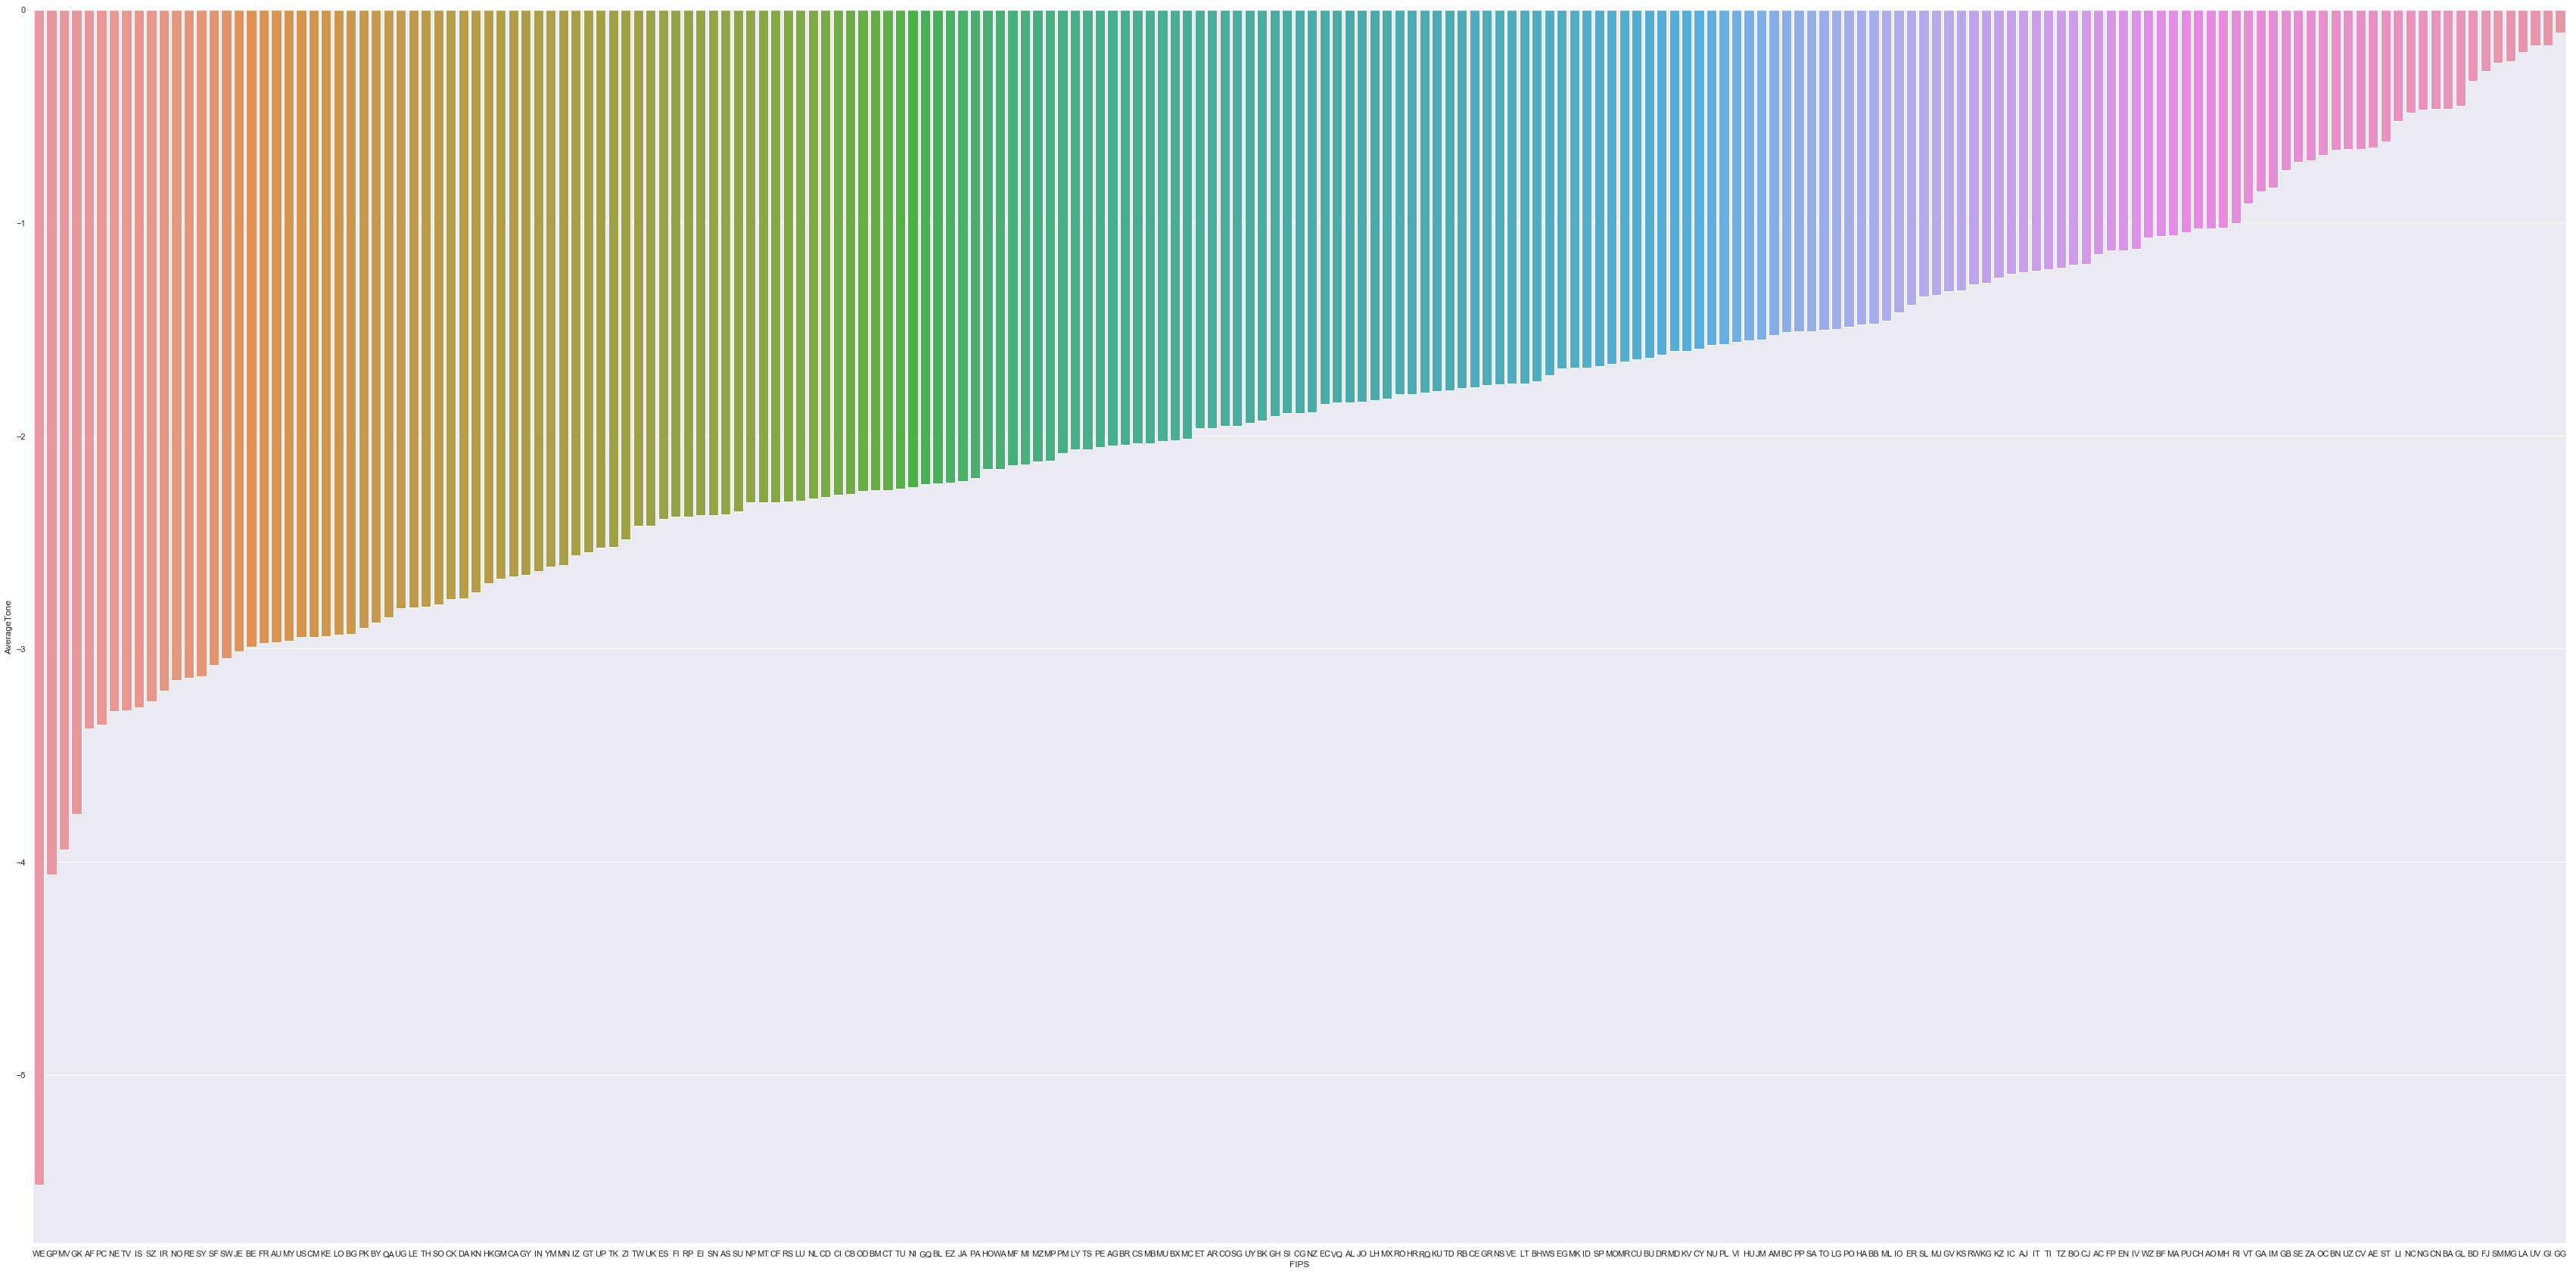

In [25]:
avgTone_neg = avgTone.filter('AverageTone <= 0')
avgTone_neg_pandas = avgTone_neg.toPandas()
avgTone_neg_pandas.sort_values('AverageTone', ascending=True, inplace=True)

sn.set(rc={'figure.figsize':(60,30)})
plot = sn.barplot(x='FIPS', y='AverageTone',data=avgTone_neg_pandas)
plt.xlabel("FIPS Codes of countries")
plt.ylabel("The average tone")

Now, we will try to see if there is somehow a correlation between the overall Happiness of the country  and the tone of its medias.

As explained above, we join `avgToneBySourceLocation_table` with the `happiness_table` which contains the Happiness score related to each FIPS country code.

In [26]:
happiness = spark.read.option("sep", ";").option('header', 'true').csv("HappinessCustom.csv")\
    .select('FIPS', 'Happiness_score').dropna()
    
happiness = happiness.withColumn('Happiness_score', happiness["Happiness_score"].cast(FloatType()))
print(happiness.dtypes)
happiness.show()
happiness.registerTempTable("happiness_table")

[('FIPS', 'string'), ('Happiness_score', 'float')]
+----+---------------+
|FIPS|Happiness_score|
+----+---------------+
|  FI|          7.632|
|  NO|          7.594|
|  DK|          7.555|
|  IC|          7.495|
|  SZ|          7.487|
|  NL|          7.441|
|  CA|          7.328|
|  NZ|          7.324|
|  SW|          7.314|
|  AS|          7.272|
|  IS|           7.19|
|  AU|          7.139|
|  CS|          7.072|
|  EI|          6.977|
|  GM|          6.965|
|  BE|          6.927|
|  LU|           6.91|
|  US|          6.886|
|  UK|          6.814|
|  AE|          6.774|
+----+---------------+
only showing top 20 rows



In [27]:
query = """
select happiness_table.FIPS, Happiness_score, AverageTone
from happiness_table
inner join avgTone_table
on happiness_table.FIPS = avgTone_table.FIPS
"""

joinedTable = spark.sql(query)
joinedTable.show()

+----+---------------+-----------+
|FIPS|Happiness_score|AverageTone|
+----+---------------+-----------+
|  IT|            6.0|  -1.226632|
|  WA|          4.441| -2.1564388|
|  CM|          4.975| -2.9449713|
|  ML|          4.447| -1.4626036|
|  MG|          5.125|-0.24210924|
|  PK|          5.472| -2.9042194|
|  GH|          4.657| -1.9078196|
|  KZ|           5.79| -1.2593573|
|  IN|           4.19| -2.6352217|
|  MI|          3.587| -2.1356432|
|  LT|          3.808| -1.7559838|
|  GB|          4.758|-0.75436354|
|  UK|          6.814| -2.4232247|
|  AU|          7.139|  -2.968697|
|  RS|           5.81| -2.3112888|
|  TW|          6.441| -2.4235868|
|  BG|            4.5| -2.9303584|
|  IC|          7.495| -1.2405035|
|  ET|           4.35| -1.9656553|
|  UP|          4.103| -2.5247657|
+----+---------------+-----------+
only showing top 20 rows



/Users/sinangokce/anaconda3/envs/ada/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0,'The happiness score of different countries')

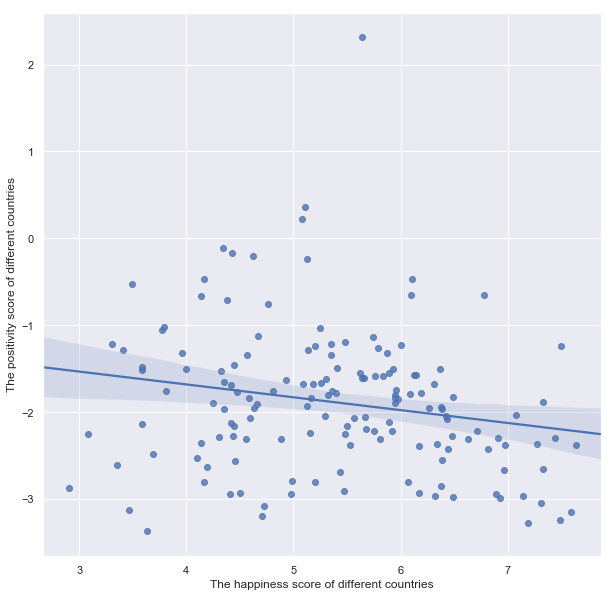

In [28]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] =10
plt.rcParams["figure.figsize"] = fig_size

joined_df = joinedTable.toPandas()
sn.regplot(x='Happiness_score', y='AverageTone', data=joined_df)
plt.ylabel("The positivity score of different countries")
plt.xlabel("The happiness score of different countries")

In [29]:
pearson_coef = joined_df['Happiness_score'].corr(joined_df['AverageTone'])
print(pearson_coef)

-0.1977625802761308


As we can see, the result is quite surprising (or deceiving). It seems that there is only a weak correlation between Happiness score and average mediatic tone, and it is rather negative. 
This would illustrate the fact that maybe the medias are not influencing too much the inhabitants' mood and that their tone is not representative of the overall atmosphere.

### 3. Is there a link with the political schedule ?

#### US 2016 ELECTION

We thought it would be interesting to see whether we recognize some trends emerging in the medias, preceeding an election. Indeed, we think that it would be in a conservative-biased media's interest to accentuate negative news in the months preceeding the Presidential Election, when the former president was Liberal, and vice-versa. 

As a first trial, we look at the average tone over the 6 months preceeding the last US presidential election which lead to the election of D. Trump on the 08/11/2016, and compare it to the overall tone.

We the following query was run on Google BigQuery to get the average tone for US sources :

<img src="query_US_sourceAvgTone.png" alt="drawing" width="700"/>

In [ ]:
US_overall_sourceTone = spark.read.option("sep",",").option('header', 'true')\
    .csv("US_sourceAvgTone.csv")
US_overall_sourceTone = US_overall_sourceTone\
    .withColumn('AverageTone', US_overall_sourceTone['AverageTone'].cast(FloatType()))
US_overall_sourceTone.show()

US_overall_sourceTone.registerTempTable('US_sourceAvgTone_table')

The following query imposed an additionnal filter on the mention date, to keep only mentions of the 6 months before the elections :

<img src="query_US_electionPreceeding_sourceAvgTone.png" alt="drawing" width="800"/>

In [30]:
US_electionPreceeding_sourceTone= spark.read.option("sep",",").option('header', 'true')\
    .csv("US_electionPreceeding_sourceAvgTone.csv")
US_electionPreceeding_sourceTone = US_electionPreceeding_sourceTone\
    .withColumn('AverageTone_electionPreceeding', US_electionPreceeding_sourceTone['AverageTone'].cast(FloatType()))
US_electionPreceeding_sourceTone.show()

US_electionPreceeding_sourceTone.registerTempTable('US_electionPreceeding_sourceAvgTone_table')

+--------------------+-----------+
|   MentionSourceName|AverageTone|
+--------------------+-----------+
|        brynmawr.edu|        0.0|
|         umhoops.com|        0.0|
|     celectrical.com|        0.0|
|        calbears.com|        0.0|
|broadbandbreakfas...|        0.0|
|       skiracing.com|        0.0|
|    leroyfcpress.com|        0.0|
|illinoisentertain...|        0.0|
|     cwuobserver.com|        0.0|
|neworleanssaints.com|        0.0|
|    pacifictakes.com|        0.0|
|   techfragments.com|        0.0|
|   battellemedia.com|        0.0|
|   thelocalvoice.net|        0.0|
|     bleedinblue.com|        0.0|
|acmepackingcompan...|        0.0|
|     akhbar-tech.com|        0.0|
|        dxcoffee.com|        2.0|
|       myballard.com|       -2.5|
|        sfappeal.com|       -5.5|
+--------------------+-----------+
only showing top 20 rows



In [ ]:
query_merge = """
select US_sourceAvgTone_table.MentionSourceName, AverageTone, AverageTone_electionPreceeding
from US_sourceAvgTone_table
inner join US_electionPreceeding_sourceAvgTone_table
on US_sourceAvgTone_table.MentionSourceName = US_electionPreceeding_sourceAvgTone_table.MentionSourceName
"""

AvgTone_comparision = spark.sql(query_merge)

AvgTone_comparision = AvgTone_comparision\
    .withColumn('relativeChange', (AvgTone_comparision.AverageTone_electionPreceeding - AvgTone_comparision.AverageTone)/abs(AvgTone_comparision.AverageTone))

AvgTone_comparision_pandas = AvgTone_comparision.toPandas()
AvgTone_comparision_pandas.sort_values('relativeChange', ascending=True, inplace=True)

sn.set(rc={'figure.figsize':(60,30)})
plot = sn.barplot(x='MentionSourceName', y='relativeChange',data=AvgTone_comparision_pandas)
fig = plot.get_figure()

Then, we plan in the future to study US media bias to see if it correlates with our initial assumption, for example using this ranking : <a href="https://www.washingtonpost.com/news/the-fix/wp/2014/10/21/lets-rank-the-media-from-liberal-to-conservative-based-on-their-audiences/?noredirect=on&utm_term=.9f8e2e247583"/> Ranking the media from liberal to conservative </a>.

In the future we could also extend this study to elections in other countries. However, we have to keep in mind that the timeframe avaiblable in the dataset is very short. 

## Future queries

<ul> 
   <li>Which event types are associated with negative tones ? </li>

   <li> Is there a correlation between the negativity of a news and the number of mentions ? The duration of its mediatic coverage ? </li>
</ul>

AJOUTER AUTRES

From now, we will use the dataset available on google [BigQuerry](https://bigquery.cloud.google.com/table/gdelt-bq:gdeltv2.events) service. 

To be able to study the representation of one country by the media of another, we decided join the Mention and the Event. From the first one we retrive the tone (*MentionDocTone*) of the mention and the location of the source, based on *source_by_country*. From the latter we get the [CAMEO](https://www.gdeltproject.org/data/documentation/CAMEO.Manual.1.1b3.pdf) code and the location of the event.

After uploading *source_by_country.csv* we used the folowing SQL querry to retrives our data. 

**Let's see what it's all about**

We will perform a few basic analysis to describe our data. 

In [269]:
output_intercountry_tone_count = pd.read_csv(data_folder+'output_intercountry_tone_count_table', \
                                             dtype={'EventRootCode': np.str})

In [270]:
output_intercountry_tone_count.head()

,EventRootCode,LocMention,LocEvent,AverageTone,NumberOfInterMentions
0,X,VE,NaN,-1.694915,2
1,--,AS,NaN,-5.860806,2
2,--,AS,AS,-3.122265,5
3,--,CA,NaN,-0.425331,6
4,--,CA,CA,-0.700771,2


In [271]:
output_intercountry_tone_count.dtypes

EventRootCode             object
LocMention                object
LocEvent                  object
AverageTone              float64
NumberOfInterMentions      int64
dtype: object

In [228]:
output_intercountry_tone_count.describe()

,AverageTone,NumberOfInterMentions
count,512369.000000,5.123690e+05
mean,-2.925045,2.404662e+03
std,2.796798,1.286880e+05
min,-26.153846,1.000000e+00
25%,-4.709830,4.000000e+00
50%,-2.957921,1.700000e+01
75%,-1.184497,1.160000e+02
max,19.047619,4.578016e+07


No incoherent numerical values. Let's check the other columns. 

In [272]:
output_intercountry_tone_count.LocEvent.unique()

array([nan, 'AS', 'CA', 'ES', 'LY', 'EI', 'RQ', 'UP', 'CH', 'JA', 'JO',
       'UK', 'US', 'AF', 'PK', 'GM', 'NO', 'AE', 'NS', 'NL', 'AA', 'FO',
       'KS', 'BB', 'BG', 'GL', 'RS', 'DA', 'GJ', 'RB', 'FR', 'TU', 'DO',
       'NZ', 'IR', 'SP', 'SW', 'IT', 'GR', 'AC', 'RO', 'MX', 'MN', 'CU',
       'MG', 'CV', 'SM', 'MJ', 'CN', 'AY', 'RE', 'SE', 'TT', 'MA', 'TV',
       'ST', 'HO', 'MP', 'IO', 'PM', 'GH', 'BY', 'WE', 'BD', 'KG', 'CY',
       'TX', 'NR', 'WA', 'MO', 'MI', 'SY', 'NF', 'UV', 'FG', 'LT', 'SO',
       'JM', 'IC', 'KZ', 'TH', 'PF', 'MK', 'SL', 'TW', 'OD', 'TN', 'QA',
       'NG', 'PA', 'VE', 'GA', 'GG', 'GQ', 'GZ', 'VQ', 'WI', 'LU', 'MU',
       'TD', 'UY', 'NI', 'SN', 'KV', 'AG', 'AL', 'MZ', 'CO', 'LI', 'BU',
       'IM', 'TI', 'PG', 'IV', 'AV', 'LO', 'VM', 'PU', 'PP', 'IN', 'HU',
       'CS', 'CI', 'NU', 'SI', 'EZ', 'RM', 'BM', 'IS', 'SF', 'FI', 'MH',
       'CG', 'EN', 'BE', 'ET', 'EG', 'FP', 'PE', 'BA', 'VI', 'AU', 'PO',
       'KR', 'HR', 'CB', 'KN', 'BK', 'SV', 'DR', 'VT

In [273]:
output_intercountry_tone_count.LocEvent.isna().sum()

4494

In [274]:
output_intercountry_tone_count.EventRootCode.unique()

array(['X', '--', '01', '02', '03', '04', '05', '06', '07', '08', '09',
       '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20'],
      dtype=object)

In [277]:
output_intercountry_tone_count.EventRootCode.unique()

array(['X', '--', '01', '02', '03', '04', '05', '06', '07', '08', '09',
       '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20'],
      dtype=object)

In [278]:
np.sum([(output_intercountry_tone_count['EventRootCode'] == '--') | (output_intercountry_tone_count['EventRootCode'] == 'X')])

27

The data seems to be quite clean. Indeed, event if we have some undesirable values, most of the time we can use the other colums to extract informations. 
Since there is a lot of row containing NaN for the Location of the event, it is a bad idea to drop all of them, since they still contain valuable information. For exemple, the tone of the media for a particular event type. 
Depending on the futur calculations, we will be careful to use only the relevenant rows and columns. 

**CAMEO dictionnary**

We copy/pasted the list in [CAMEO](https://www.gdeltproject.org/data/documentation/CAMEO.Manual.1.1b3.pdf) and used the power of panda to transform it easily in a dicitonnary. 

In [253]:
CAMEO_translation = pd.read_csv(data_folder+'CAMEO_code', header=None, sep=':', names=['Code', 'Translation'], dtype={'Code': np.str})
CAMEO_translation.set_index('Code',inplace=True)
CAMEO_translation.head()

,Translation
Code,
01,MAKE PUBLIC STATEMENT
010,"Make statement, not specified below"
011,Decline comment
012,Make pessimistic comment
013,Make optimistic comment


In [279]:
CAMEO_translation_dict = CAMEO_translation.to_dict()

Now it is time to plot some stuff ! 

In [280]:
group_by_CAMEO_df = output_intercountry_tone_count.drop(output_intercountry_tone_count[output_intercountry_tone_count.EventRootCode == '--'].index)
group_by_CAMEO_df = group_by_CAMEO_df.drop(group_by_CAMEO_df[group_by_CAMEO_df.EventRootCode == 'X'].index)
group_by_CAMEO_df.replace({'EventRootCode': CAMEO_translation_dict['Translation']}, inplace=True)                      

In [265]:
group_by_CAMEO_df = group_by_CAMEO_df.groupby('EventRootCode').agg({'NumberOfInterMentions':'sum', 'AverageTone':'mean'} )
group_by_CAMEO_df.reset_index(inplace=True)
group_by_CAMEO_df.sort_values('AverageTone')

,EventRootCode,NumberOfInterMentions,AverageTone
1,ASSAULT,19774059,-5.717893
17,USE UNCONVENTIONAL MASS VIOLENCE,469609,-5.165597
2,COERCE,56613030,-5.010890
10,FIGHT,93354809,-4.874603
12,PROTEST,10858944,-4.208912
5,DISAPPROVE,78121068,-4.205012
16,THREATEN,18119791,-4.108639
14,REDUCE RELATIONS,11503897,-3.380096
11,INVESTIGATE,27449677,-3.249702
15,REJECT,33835158,-3.158667


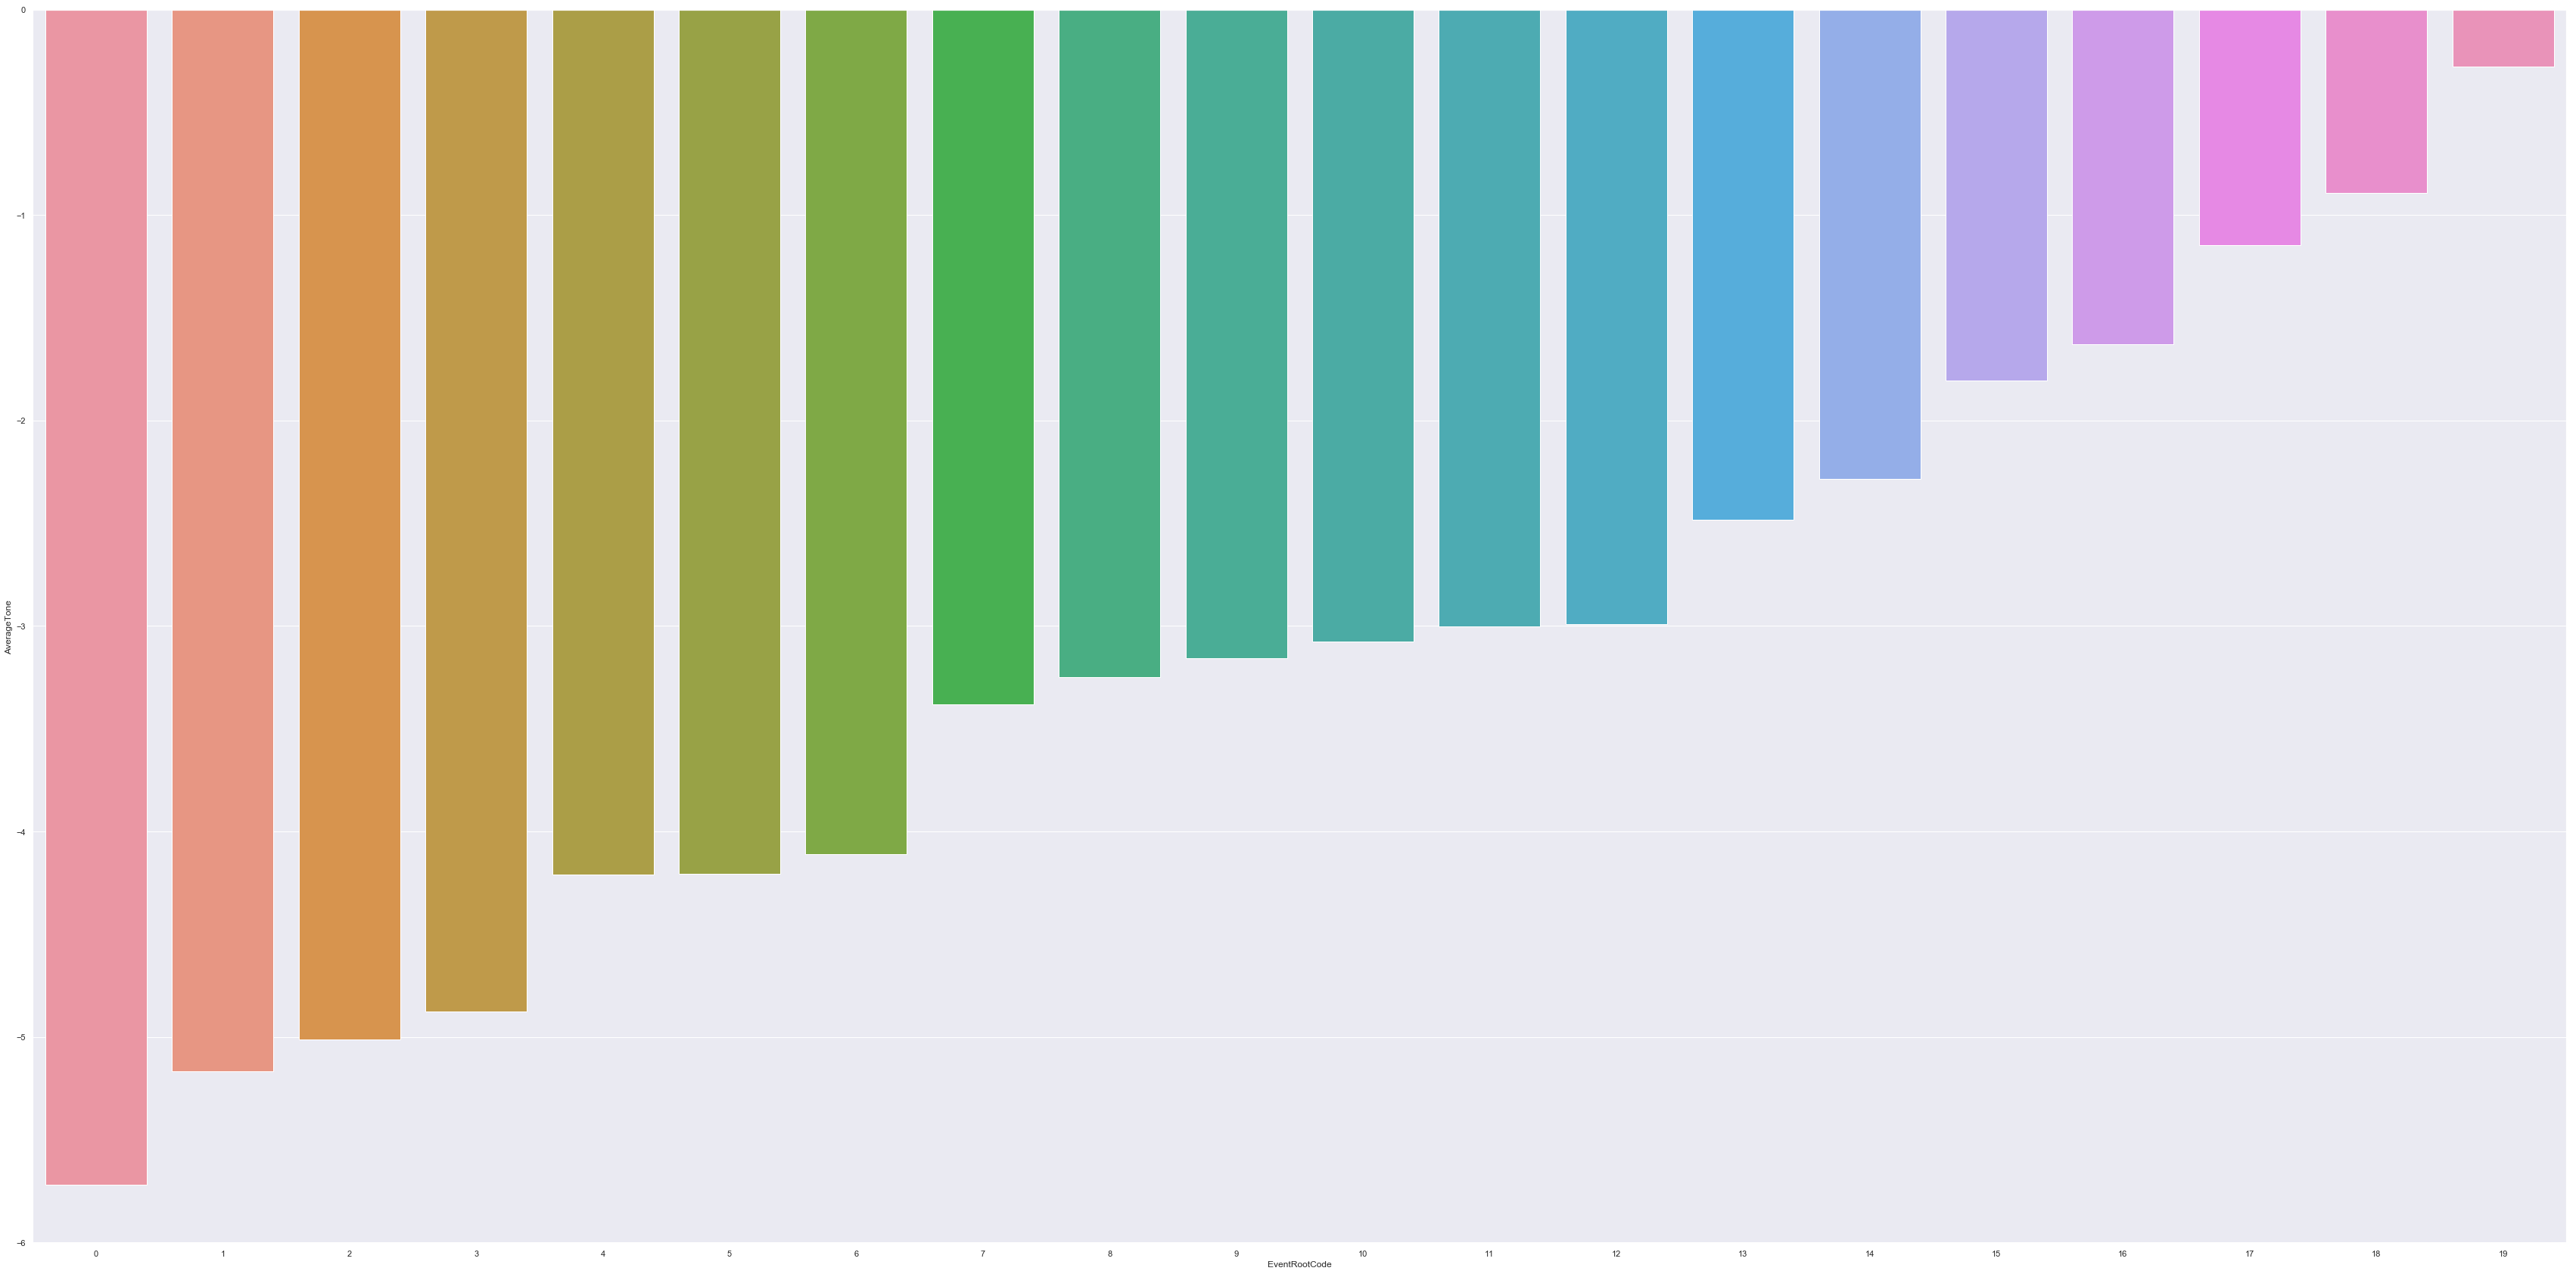

In [266]:
toPlot1 = group_by_CAMEO_df.sort_values(['AverageTone'], ascending=True).reset_index(drop=True)
ax = sn.barplot(toPlot1.index, toPlot1.AverageTone)
ax.set(xlabel='EventRootCode', ylabel='AverageTone')
fig = ax.get_figure()

At first sight, this graph seems to ne coherent with common sense. The more the event is violent or conflictual, the more it get a negative tone.

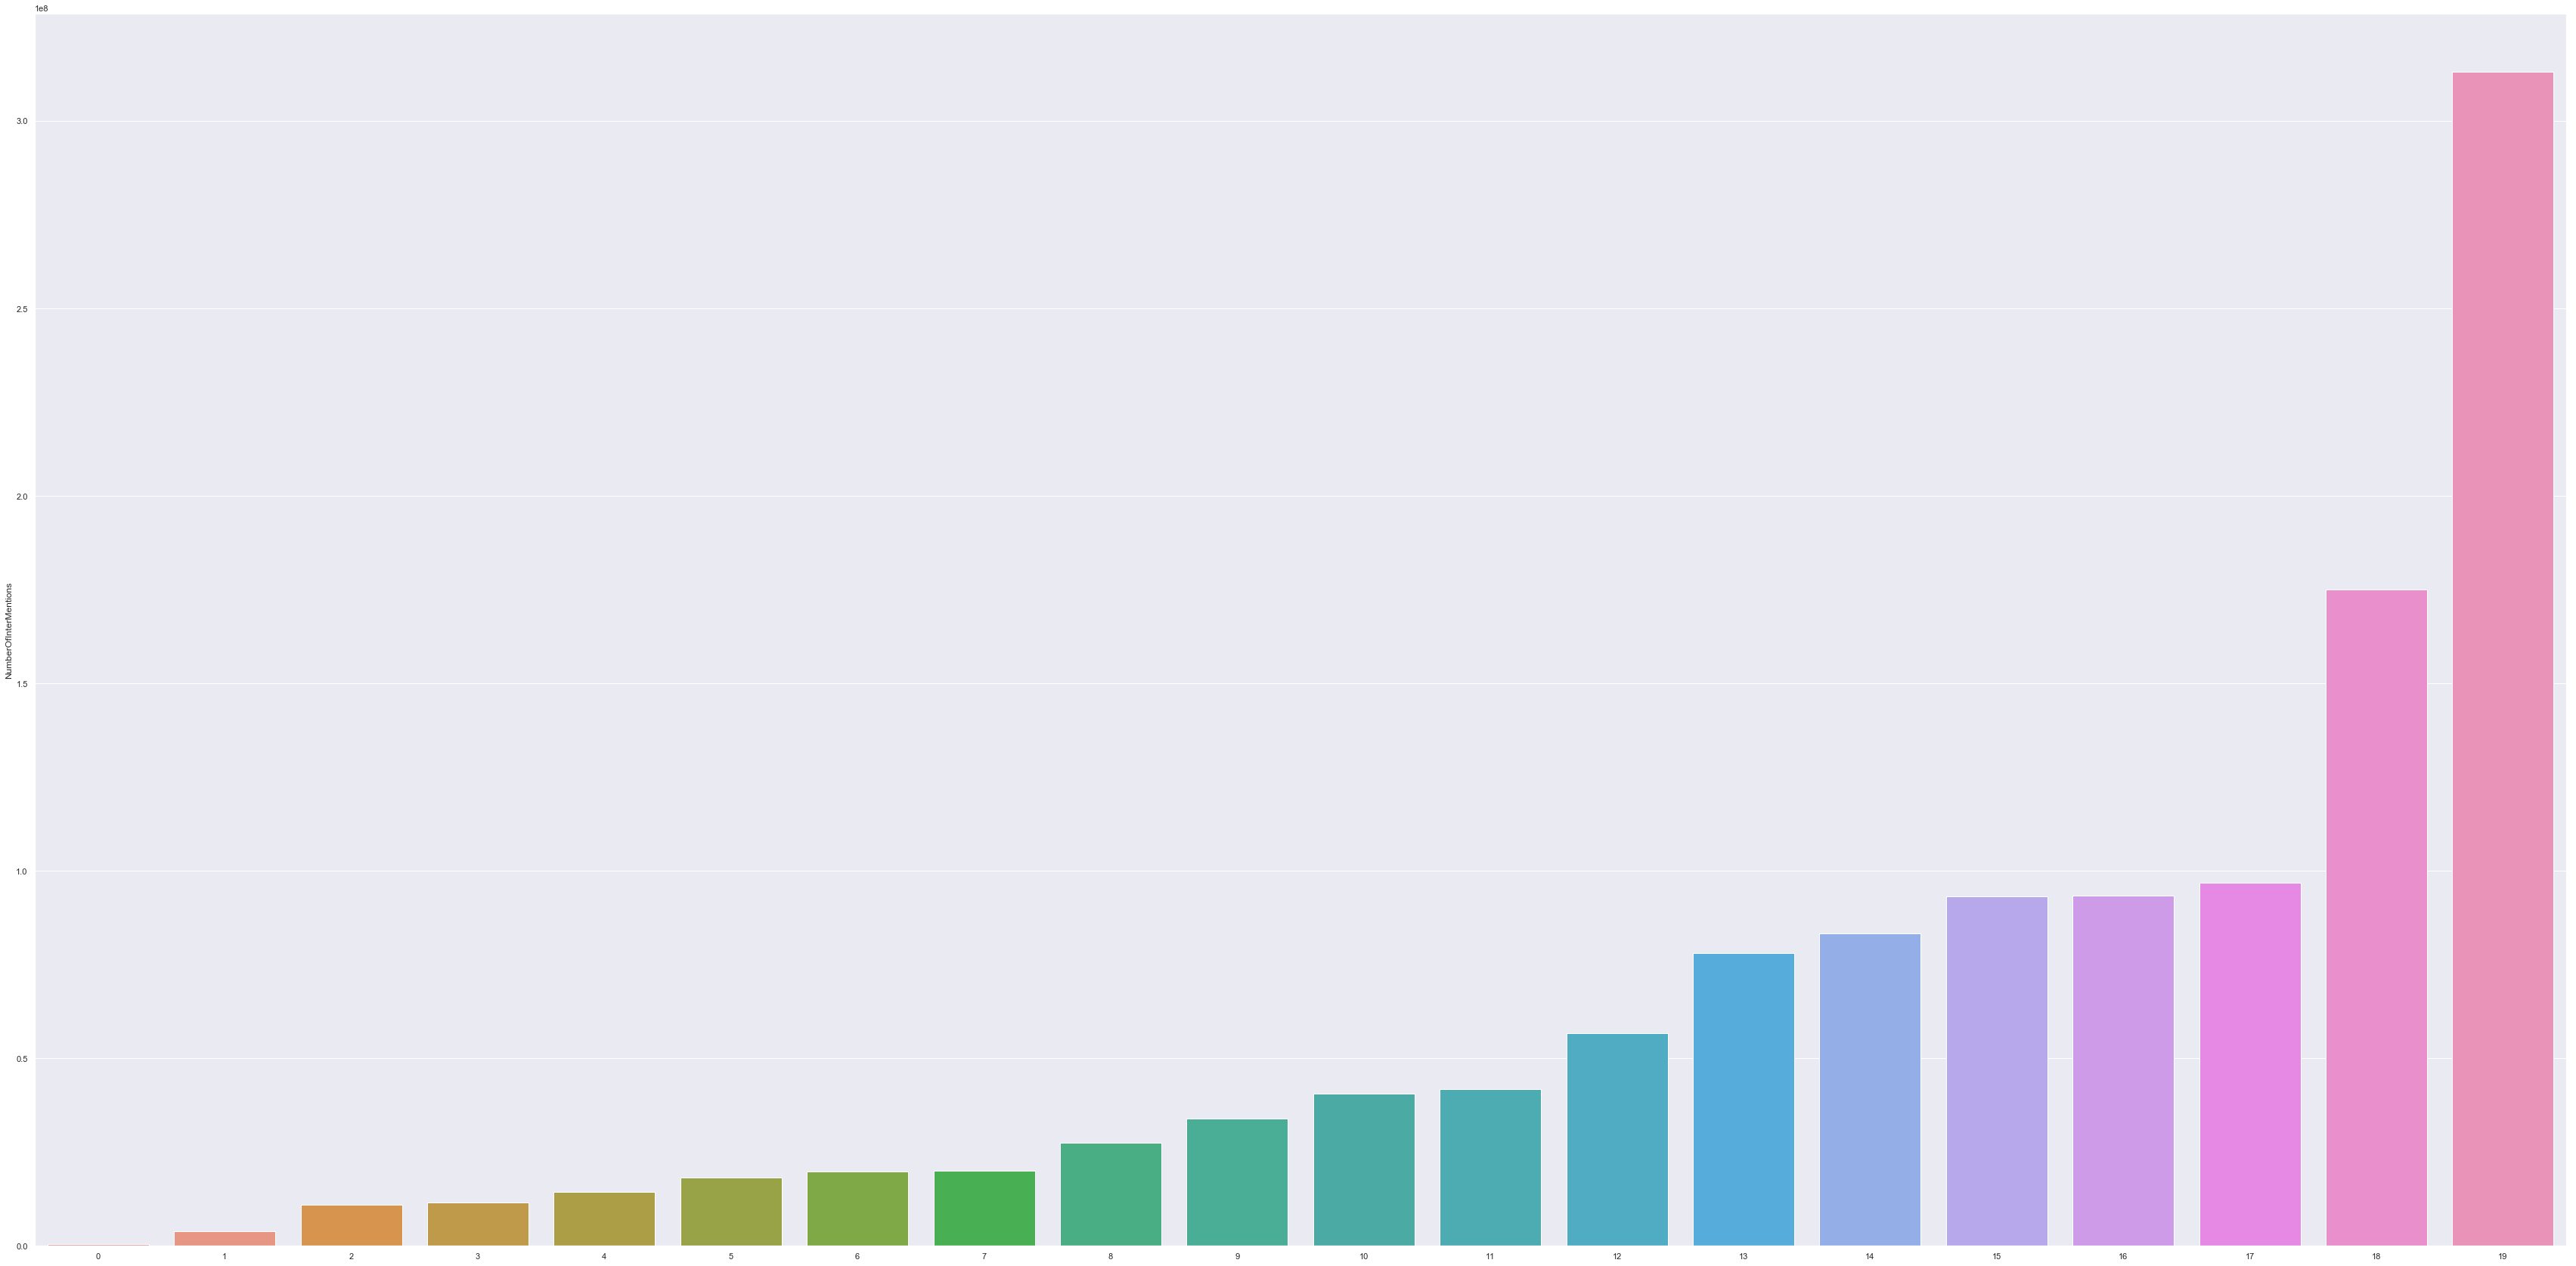

In [239]:
toPlot2 = group_by_CAMEO_df.sort_values(['NumberOfInterMentions'], ascending=True).reset_index(drop=True)
ax = sn.barplot(toPlot2.index, toPlot2.NumberOfInterMentions)
fig = ax.get_figure()

In [268]:
group_by_CAMEO_df.sort_values('NumberOfInterMentions')

,EventRootCode,NumberOfInterMentions,AverageTone
17,USE UNCONVENTIONAL MASS VIOLENCE,469609,-5.165597
8,EXHIBIT FORCE POSTURE,3837584,-3.076163
12,PROTEST,10858944,-4.208912
14,REDUCE RELATIONS,11503897,-3.380096
4,DEMAND,14330131,-2.991537
16,THREATEN,18119791,-4.108639
1,ASSAULT,19774059,-5.717893
7,ENGAGE IN MATERIAL COOPERATION,19978098,-1.628632
11,INVESTIGATE,27449677,-3.249702
15,REJECT,33835158,-3.158667


This second graph show us that we can still have faith in humanity since most of the mentions are for rather peaceful event code.